# ORION Orientation Estimation Using Commodity Wi-Fi

<img src="//dl.dropboxusercontent.com/s/xlcw56r9k66b8o5/exp_setup.jpg?dl=0" style="width: 200px;">

## Implementation 

###  Experimentation Setup
We have implemented the system using the Intel Wi-Fi Link 5300 AGN NICs. The firmware of this COTS Wi- Fi card was modified in order to extract the CSI matrices through the Intel CSI tool for 802.11n HT packets . In case of OFDM systems for instance Wi- Fi, we are able to extract a CSI matrix for each sub-carrier. In our case the Wireless NIC offers up to 30 subcarriers. We use instead the 5 GHz band with 20MHz of bandwidth. 
We set up our wireless cards in the injection mode, which avoids the need of association with an AP and allows raw Wi-Fi packets transmission. 

We setup two unifom linear antenna arrays. We use a classical 5dbi ominidirectional compatible with 2.4 GHz as well as the 5GHz band. As we are using the 5.32 GHz band for our system, we respect a 2.8cm of inter-antenna spacing, which corresponds to halfwavelength. These ULAs are connected to the terminal through extension cables in order to have liberty of mouvement, which is essential for our experimentation. The cables are 3 meters long and compatible with both the wi-fi bands with a 2db signal attenuation for 2.4 Ghz band. 

###  Wireless Card Configuration
The transmission is controlled by disabling the antenna selection algorithm and by specifying the desired number of antennas, streams and transmission technique (SM). The rotation is realized using extension cables that connect the coplanar transmitter and receiver antenna arrays to the access points.
In order to specify correctly the antenna mapping as well the number of streams used for the transmision, we change the monitor_tx_rate file, after making sure that all the previous steps for collecting csi were respected, we could for example lauch the following command:

```bash
sudo echo 0x4101 |sudo tee /sys/kernel/debug/ieee80211/phy0/iwlwifi/iwldvm/debug/monitor_tx_rate
```
This command  is meant for sending 1 stream on the first antenna. 
In fact there the number of streams that are sent is dependent on the MCS index used .

If we want to build a reate index we need to choose and appropriate MCS index corresponding to the number of streams. For example for sending two streams we choose the MCS index number 9 (make sure that the index is in hexadecimal). For choosing the antenna involved in the transmission we need to apply the appripriate mask:
```
0x04000 for the first antenna
0x08000 for the second antenna
0x10000 for the third antenna.
```
We use the HT leagacy packet format by using the flag 0x100.

And thus if we want to send 2 streams on the second and third antenna using HT leagacy packets, the appropriate rate would be:
```
0x18109=0x08000+0x10000+0x100+0x9
```
And thus the command used is as follows:
```bash
sudo echo 0x18109 |sudo tee /sys/kernel/debug/ieee80211/phy0/iwlwifi/iwldvm/debug/monitor_tx_rate.

```
For further details check: 
https://github.com/dhalperi/linux-80211n-csitool/blob/csitool-3.13/drivers/net/wireless/iwlwifi/dvm/commands.h#L245-L334

For the transmission we choose the injection mode based on lorcon-old.

## Joint Angle of arrival Angle of Departure Estimation



We  jointly estimate AoA and AoD using a 2D music algorithm on phase corrected CSI matrices collected through out the experiment for a subcarrier.

The figure shown below represent the vaules computed for the following pseudo-spectrum:

$$
\begin{equation}
\textbf{P}(\theta_i,\phi_i)=\frac{1}{(\textbf{a}_r(\theta_i) \otimes \textbf{a}_t(\phi_i))^H.\textbf{Q}_n.\textbf{Q}_n^H(\textbf{a}_r(\theta_i) \otimes \textbf{a}_t(\phi_i))}
\end{equation}
$$
with $\theta_i $ is the angle of arrival and $\phi_i$ is the angle of departure. The peak represent the AoA and AoD estimate.

<img src="//dl.dropboxusercontent.com/s/otf92m6mbvvh1m5/dod-doa.png?dl=0" style="width: 500px;"/>

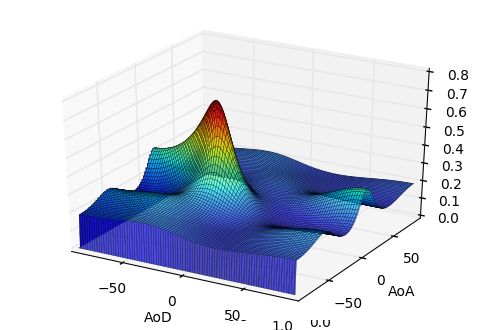

array([ -4., -24.])

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from music import *
csi_corr='csi_corr.dat'
csi_target='csi_target.dat'
music(csi_corr, csi_target, 2, 3, 0.5, 0.5,640)

KeyboardInterrupt: 

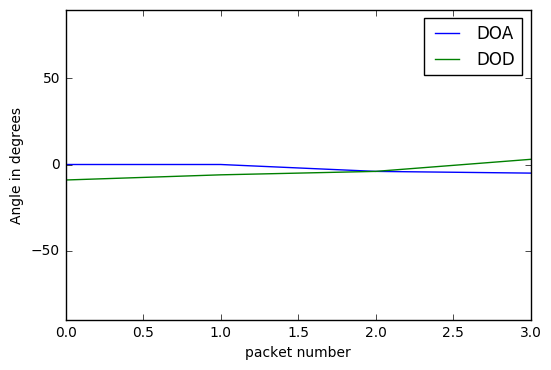

In [2]:
%matplotlib inline
from music_pl import *
from IPython import display
import time

x = []
y = []
z = []

s = phase_correction(csi_corr, csi_target)    

for i in range(1900):
    x = np.append(x, i)
    o=music_pl(s, 2, 3, 0.5, 0.5,i)
    y = np.append(y, o[0])
    z = np.append(z, o[1])
    plt.gca().cla() 
    plt.plot(x,y,label='DOA')
    plt.plot(x,z,label='DOD')
    plt.ylabel('Angle in degrees')
    plt.xlabel('packet number')
    plt.legend()
    plt.ylim(-90, 90)
    display.clear_output(wait=True)
    display.display(plt.gcf()) 


In [ ]:
angle=np.array(np.squeeze([[y],[z]]))
angle.shape

In [5]:
import pandas as pd 
df = pd.DataFrame(angle)
df.to_csv("exp_meas3.csv",header=None)

###  Smoothing Angle Estimations

As show in the figure above, the estimates are jittery  with a strong presence of outliers.Thus, in order to smoothen our estimates, we apply an outlier detector on the measurement data before using a kalman filter to  mitigate the statistical noise.

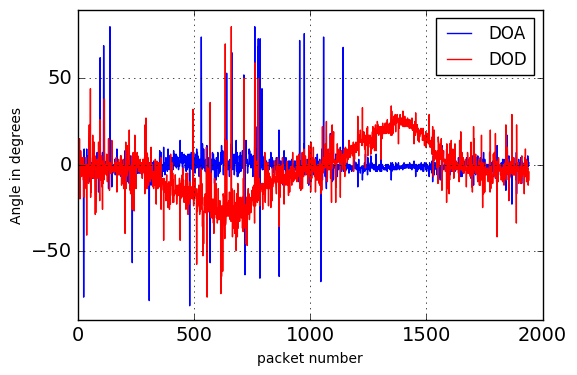

In [6]:
plt.figure()
plt.grid(True)
plt.ylabel('Angle in degrees')
plt.xlabel('packet number')
plt.plot(y,'b',linewidth='1',label='DOA') 
plt.plot(z,'r',linewidth='1',label='DOD') 
plt.tick_params(labelsize=14)
plt.legend()
plt.ylim(-90, 90)
plt.show()

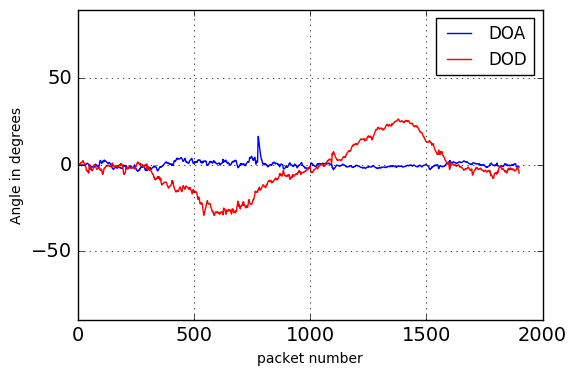

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from kalman_fil import *

DOA, DOD=kalman_fil("exp_meas.csv")

plt.figure()
plt.grid(True)
plt.ylabel('Angle in degrees')
plt.xlabel('packet number')
plt.plot(DOA,'b',linewidth='1',label='DOA') 
plt.plot(DOD,'r',linewidth='1',label='DOD') 
plt.tick_params(labelsize=14)
plt.legend()
plt.ylim(-90, 90)
plt.show()

And so after applying a hampel oultlier detector and a kalman filter on a our estimated data we have clearly less noise an an overall better accuracy.

To have acess to this notebook and the code used in this example please check the following link:
https://github.com/naoufal51/Orion